# GECAMTools v0.0.9.5使用说明

1. 所需环境  
    1.1 系统环境：windows、linux、mac  
    1.2 python环境：python版本>=3.6 (不建议安装python 3.9及以上版本)

2. 安装流程  
    2.1 下载源程序  
    gecamTools-master.zip  
    
    2.2 安装  
    2.2.1 仅使用基本功能(即无需生成响应矩阵)
    >   使用pip进行源码安装，自动安装GECAMTools以及相关依赖库
        `pip install gecamTools-master.zip`
        将会自动安装GECAMTools以及相关依赖库

        建议使用Anaconda创建独立的python环境使用，防止出现不同软件的依赖库版本不兼容问题。 [Miniconda使用说明](https://www.jianshu.com/p/7299c2d4d170)


    2.2.2 使用全部功能(包含生成响应矩阵)
    linux或mac中CALDB安装流程:
    >   (1) 从公共服务器上下载最新版的CALDB.(截止2022-03-18，最新版本CALDB的路径为：/gecamfs/soft/CALDB)
        (2) 标定库CALDB下载之后将source /your directory of caldb/software/tools/caldbinit.sh 这句话放环境文件里，
        /your directory of caldb 这个是用户下载下来的 CALDB 的目录
        (3) 完成之后， source 环境文件，可进入 python，通过 `import RSP_generator` 来检验标定库是否安装成功

    windows中CALDB安装流程(测试于win10):
    >   (1) 从公共服务器上下载最新版的CALDB.(截止2022-03-18，最新版本CALDB的路径为：/gecamfs/soft/CALDB)
        (2) 添加系统变量： 变量名为：CALDB， 地址为CALDB对应的根目录，例：E:\gecam\CALDB
        (3) 在python环境的site-packages中新建一个CALDB.pth文件
            可通过以下方法找到python或者conda对应的目录：
            >>> import os
            >>> os.path.dirname(os.__file__)
            >>> 'C:\\Users\\用户名\\.conda\\envs\\gecamTools\\lib'
            因此新建文件：C:\Users\用户名\\.conda\envs\gecamTools\Lib\site-packages\CALDB.pth
            CALDB.pth中内容为CALDB中software文件夹路径：
            E:\gecam\CALDB\software
        (4) 完成之后，可进入 python，通过 `import RSP_generator` 来检验标定库是否安装成功


    
    2.3 测试  
    `import gecam`

3. 卸载流程  
    `pip uninstall GECAMTools`



## 当前版本更新内容
1. 修复选取源时间段不包含触发时刻时，导致画光变时异常
2. 修复显示光变部分，计算误差错误

## 获取示例所用的测试数据

测试数据（gbg_evt_tn210511_112749_fb_v00.fits）的下载链接： [点击下载](https://ihepbox.ihep.ac.cn/ihepbox/index.php/s/iEE9AZQyNuJljr0)   

测试数据是通过IHEP BOX分享的，使用高能所账号登录即可

## 功能列表

1. 显示光变
2. 显示能谱
3. 生成能谱文件
4. 时间转换
5. 生成响应文件（依赖于GECAM CALDB）

# 1. 基本功能

## 1.1 时间转换

In [1]:
import numpy as np

from gecam.time import GecamMet

In [20]:
trig_met = 74431600.6

In [21]:
# met转时间字符串
trig_time_str = GecamMet(trig_met).iso
# met转datetime
trig_datetime = GecamMet(trig_met).datetime
# met转MJD
trig_mjd = GecamMet(trig_met).mjd

trig_time_str, trig_datetime, trig_mjd

('2021-05-11T11:26:40.600000',
 datetime.datetime(2021, 5, 11, 11, 26, 40, 600000, tzinfo=datetime.timezone.utc),
 59345.4768587963)

In [22]:
# 时间字符串转met
met1 = GecamMet.from_iso(trig_time_str)
# datetime转met
met2 = GecamMet.from_datetime(trig_datetime)
# MJD转met
met3 = GecamMet.from_mjd(trig_mjd)

met1, met2, met3

(<GecamMet seconds = 74431600.600000>,
 <GecamMet seconds = 74431600.600000>,
 <GecamMet seconds = 74431600.600000>)

# 2. 多个探头批量分析

## 2.1 读取事例数据（1级daily或trigger事例数据）

In [1]:
from gecam.data.evt import Evt
from gecam.data.spec import SpecFile
from gecam.data.detector import GRD, CPD
from gecam.plot.light_curve import LightCurveFigure
from gecam.plot.spectrum import SpectrumFigure

import matplotlib.pyplot as plt

In [2]:
# 事例文件路径
evt_path = r"D:\sougou_download\gbg_evt_tn210511_112749_fb_v00.fits"
evt = Evt.open(evt_path)

### 2.1.1 批量选取探头

In [26]:
# 示例：选取10个高增益，15个低增益
choose_det = []

choose_det.extend([GRD(number=i, gain_type="high") for i in range(1, 11)])

choose_det.extend([GRD(i, "low") for i in range(11, 26)])

[det.full_name for det in choose_det]

['g01H',
 'g02H',
 'g03H',
 'g04H',
 'g05H',
 'g06H',
 'g07H',
 'g08H',
 'g09H',
 'g10H',
 'g11L',
 'g12L',
 'g13L',
 'g14L',
 'g15L',
 'g16L',
 'g17L',
 'g18L',
 'g19L',
 'g20L',
 'g21L',
 'g22L',
 'g23L',
 'g24L',
 'g25L']

## 2.2 查看多个探头的叠加光变

In [3]:
# 获取触发事例数据中的触发时间
trig_met = evt.info.trig_met
# 选择多个探头，例：GRD18（包含高低增益），GRD19(高增益)
chooose_det = [GRD(18, gain_type="both"), GRD(19, gain_type="high")]

# 光变的整体时间区间
lc_time_range = (trig_met - 50, trig_met + 60)
# 源时间区间
src_time_range = (trig_met - 5, trig_met + 12)
src_time_range2 = (trig_met + 9, trig_met + 15)
# 多段本底的时间区间
bg_time_range_list = [[trig_met - 40, trig_met - 30], [trig_met + 30, trig_met + 40]]
# 光变的时间bin，单位：秒
time_bin = 1

# 是否选取推荐事例，True:只选取推荐事例  False:选取全部事例
only_recommend = True

lc_data, lc_fig = evt.plot_light_curve(chooose_det, time_range=lc_time_range, time_bin=time_bin,
                                       only_recommend=only_recommend, src_range=src_time_range,
                                       bg_range=bg_time_range_list)
# lc_fig.axes[0].set_xlim([0,10])
lc_x, lc_y, _lc_y_err = lc_data

C:\Users\10500\PycharmProjects\gecamTools\gecam\data\evt.py:568: UserWarning: Dead time calculations must distinguish between high and low gain, and the current gain type is both
  "Dead time calculations must distinguish between high and low gain, and the current gain type is both")


ValueError: cannot reshape array of size 414520 into shape (1,1)

In [6]:
import numpy as np
a=np.array([1,2])

a[(True)]

array([[1, 2]])

## 2.3 查看多个探头的叠加能谱

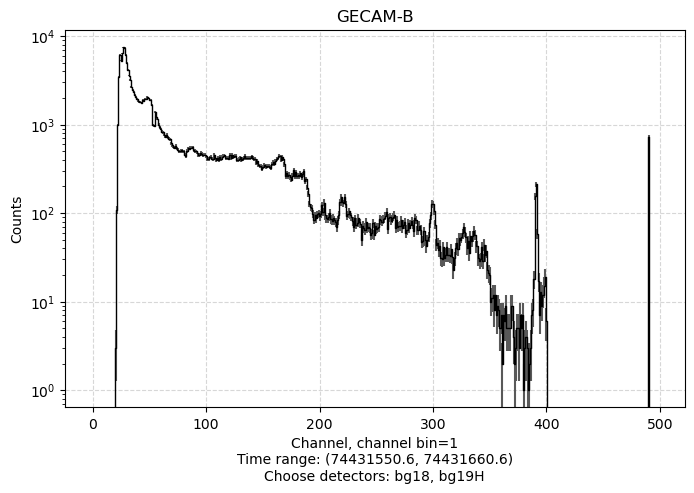

In [6]:
# 获取触发事例数据中的触发时间
trig_met = evt.info.trig_met

# 选择多个探头，例：GRD18（包含高低增益），GRD19(高增益)
chooose_det = [GRD(18, gain_type="both"), GRD(19, gain_type="high")]

# 光变的整体时间区间
time_range = (trig_met - 50, trig_met + 60)
# 光变的时间bin，单位：秒
time_bin = 1

# 是否选取推荐事例，True:只选取推荐事例  False:选取全部事例
only_recommend = True

# 能道分bin， 整数(均匀分bin)或一维数组(自定义分bin)
channel_bin = 1
spectrum_data, steptrum_fig = evt.plot_spectrum(chooose_det, time_range=time_range,
                                                channel_bin=channel_bin, only_recommend=only_recommend)
plt.show()

## 2.4 生成多个探头的响应文件

In [1]:
from gecam.data.posatt import PosAtt
from gecam.coord import radec_to_thetaphi
from gecam.utils import rsp_utils
from gecam.data.detector import GRD

# 读取posatt文件
posatt_obj = PosAtt.open(r"gb_posatt_tn210511_112749_v00.fits")

# 选定met时间，或使用触发时间 evt.info.trig_met
choose_met = 74431600.6

# 获取时间点对应的卫星姿态（四元数）
quat = posatt_obj.get_quat(choose_met)

# 设定源坐标（J2000）
# 或取出触发evt文件的header中存储的源坐标: ra,dec,err_radius=evt.info.loc
ra = 317.99
dec = 59.53

# 根据源的坐标和卫星姿态计算入射角（deg）
theta, phi = radec_to_thetaphi(ra, dec, quat)

# 选择探头(必须设定增益,high 或者 low)
choose_det = GRD(18, "high")
# 必须设置探头所属的卫星， a/b
choose_det.set_satellite("b")

# 设置响应文件输出的文件夹
out_dir = "/gecam/zhangpeng/test/spec/"

# 生成单个探头（单个响应）响应文件，返回响应文件的绝对路径
rsp_out_path = rsp_utils.generate_rsp_fits(choose_det.full_name, theta, phi, choose_met, out_dir)
rsp_out_path

read CALDB in env: /gecam/CALDB_20210506
read index /gecam/CALDB_20210506/data/gecam-b/grd/caldb.indx


'/gecam/zhangpeng/test/spec/bg18H_x_evt_T118202_P036574_v20210506.rsp'

In [9]:
# 生成多个探头的响应文件（必须区分高低增益）
import os

det_rsp_list = []

for det in [GRD(18), GRD(19)]:
    temp_rsp_list = []
    for gain_type in ["high", "low"]:
        det.set_gain_type(gain_type)
        det.set_satellite("b")

        temp_rsp_path = rsp_utils.generate_rsp_fits(det.full_name, theta, phi, choose_met, out_dir)
        temp_rsp_list.append(os.path.basename(temp_rsp_path))
        print(temp_rsp_path)

    det_rsp_list.append(temp_rsp_list)

det_rsp_list

/gecam/zhangpeng/test/spec/bg18H_x_evt_T118202_P036574_v20210506.rsp
/gecam/zhangpeng/test/spec/bg18L_x_evt_T118202_P036574_v20210506.rsp
/gecam/zhangpeng/test/spec/bg19H_x_evt_T118202_P036574_v20210506.rsp
/gecam/zhangpeng/test/spec/bg19L_x_evt_T118202_P036574_v20210506.rsp


[['bg18H_x_evt_T118202_P036574_v20210506.rsp',
  'bg18L_x_evt_T118202_P036574_v20210506.rsp'],
 ['bg19H_x_evt_T118202_P036574_v20210506.rsp',
  'bg19L_x_evt_T118202_P036574_v20210506.rsp']]

## 2.5 生成多个探头的能谱文件

In [14]:
trig_met = evt.info.trig_met
choose_det = [GRD(18), GRD(19)]

# 能道分bin，[高增益，低增益]
# 整数(均匀分bin，0-498)或一维数组(自定义分bin)
channel_bins_high = 1
channel_bins_low = 1
channel_bins = [channel_bins_high, channel_bins_low]

time_bin = 1

# 多段本底时间区间
bg_range_list = [[trig_met - 40, trig_met - 10],
                 [trig_met - 40, trig_met - 10]]

# 源时间段，列表（可选择多个源时间段）
src_range_list = [
    [trig_met + 1, trig_met + 5], [trig_met + 5, trig_met + 15]
]

# 本底拟合方法，目前只有 "2pass"
bg_fit_method = "2pass"
# 本底拟合阶次
bg_fit_order = 1
# 是否只选取推荐事例
only_recommend = True

# 每个探头对应的响应文件路径（区分高低增益），建议使用相对路径
# rsp_list = [
#     ["grd18_high_gain_rsp_path", "grd18_low_gain_rsp_path"],
#     ["grd19_high_gain_rsp_path", "grd19_low_gain_rsp_path"]
# ]
# 当前设置为None,可使用上一节生成的 'det_rsp_list'
rsp_list = None

# 能谱文件的输出文件夹
out_dir = r"/gecam/zhangpeng/test/spec/"
out_dir = r"E:\gecamTools\test4/"

spec_data = evt.generate_spec_file(choose_det, src_range_list, channel_bins, bg_range_list, rsp_list,
                                   time_bin, bg_fit_method, bg_fit_order, only_recommend, out_dir)


bg18H


C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 170

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning


bg18L


C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:266: RankWarning: The fit may be poorly conditioned
  self._coeffs[i] = self._weighted_leastsq(X, y[i], w[i], False)
C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:280: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 354

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning
C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 72, 80, 208, 249, 271, 330, 348, 352, 356, 357, 362, 364, 373, 377, 383, 386, 387, 388, 397, 398, 400

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning


bg19H


C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 23

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning


bg19L


C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:280: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 107, 348, 375, 377

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning
C:\Users\10500\PycharmProjects\gecamTools\gecam\fitting\polynomial_fitter.py:204: RuntimeWarning: background model has negative value in following channel(s) (starting from 0): 87, 89, 92, 96, 98, 102, 107, 135, 301, 311, 322, 327, 328, 337, 339, 342, 343, 344, 346, 348, 358, 359, 360, 364, 374, 375, 377, 384, 387, 392, 397, 401, 403, 405, 409, 411, 412, 415, 416, 417, 418, 419, 422, 429

This error maybe eliminated by reducing the order of polynomial (the current is 1).
  RuntimeWarning


In [9]:
spec_data.keys()

dict_keys(['bg18H', 'bg18L', 'bg19H', 'bg19L'])

In [11]:
# 查看bg18H的能谱数据
spec_data_bg18H = spec_data.get("bg18H")
# 查看生成能谱前的总光变和本底光变
bg18H_lc = spec_data_bg18H.get("lc")
bg18H_bg_lc = spec_data_bg18H.get("bg_lc")

spec_list_bg18H = spec_data_bg18H.get("src_spec_list")

# 查看第一个时间段源的能谱数据
spec_list_bg18H_src1 = spec_list_bg18H[0]

src_range1, spec_bg18H, bg_spec_bg18H, net_spec_bg18H = spec_list_bg18H_src1

In [ ]:
bg18H_bg_lc.src

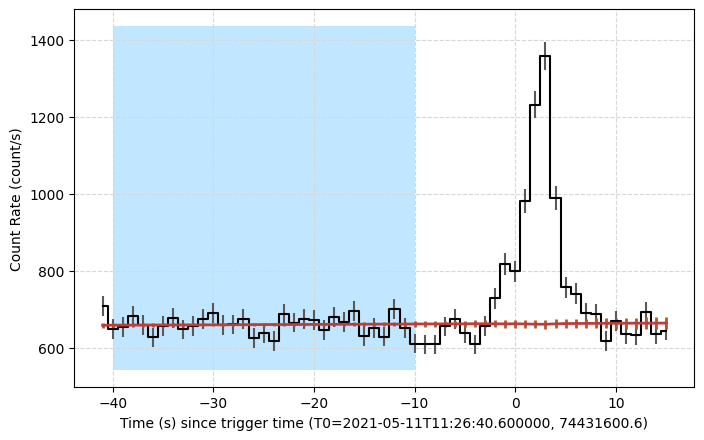

In [12]:
# 示例：检查bg18H在拟合光变时是否存在错误（参考后续的细致分析）
det_sliced_c_lc_fig = LightCurveFigure(bg18H_lc.get_plot_data(), trig_time=trig_met)
# 标记本底范围的阴影
det_sliced_c_lc_fig.add_background(bg18H_bg_lc.get_plot_data(),
                                   bg_time_range=bg18H_bg_lc.bg_time_range, label="bg")

# 查看bg18H的本底拟合评价
# channel_range=[10,200]
# bg18H_bg_lc.show_fitting_quality(channel_range=channel_range)
# plt.show()

In [11]:
# 能谱数据
# channel的每个bin的边界
channel_bins = spec_bg18H.channel_bins
# energy的每个bin的边界
energy_bins = spec_bg18H.energy_bins
# 每个channel bin的计数
counts = spec_bg18H.counts
# 每个channel bin的计数误差
count_err = spec_bg18H.counts_err

# 3 单个探头细致分析

## 3.1 读取事例文件

In [2]:
evt_path = r"D:\sougou_download\gbg_evt_tn210511_112749_fb_v00.fits"
evt = Evt.open(evt_path)

## 3.2 过滤出单个探头的数据

In [4]:
# 过滤出探头18的数据
det_events = evt.select_detector(18)

## 3.3 对于单个探头的事例，进一步过滤

### 3.3.1 如果后续将使用该数据生成能谱文件，则必须过滤增益，不能选择全增益

In [5]:
# 对于探头数据进一步的数据过滤，增益、时间范围、能量范围、能道范围、是否只使用推荐事例

# 根据增益过滤，both:全增益， high:高增益， low：低增益
# gain_type=None,

# 根据时间过滤
#time_range=None,

# 过滤能量范围或能道范围，不同时进行，如果channel_range不为None,则只过滤channel
#energy_range=None,
#channel_range=None,

# 是否只选取推荐事例
#only_recommend=True
det_sliced_events = det_events.slice(gain_type="high", only_recommend=True)

## 3.4 从过滤后的数据中提取分能段的光变

In [7]:
import numpy as np

In [43]:
# 提取触发时间
trig_met = evt.info.trig_met

# 光变的总时间范围（绝对时间）
lc_time_range = (trig_met - 50, trig_met + 60)

# 定义源时间段
src_time_range = [trig_met - 5, trig_met + 10]
# 定义本底时间段
bg_time_range_list = [[trig_met - 40, trig_met - 30],
                      [trig_met + 25, trig_met + 60]]

# 时间bin，单位秒
time_bin = np.arange(74431550.65,74431560.65,0.05)
# 能道分bin，整数为均匀分bin，一维列表为自定义分bin
channel_bin = 1

det_sliced_lc = det_sliced_events.to_light_curve(lc_time_range, time_bin, channel_bin)
# 本底拟合，拟合阶次为2
det_sliced_bg_lc = det_sliced_lc.fit_background(bg_time_range_list, fit_order=2)
# 提取源时间段的光变
det_src_lc = det_sliced_events.to_light_curve(src_time_range, time_bin, channel_bin)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [8]:
# 提取触发时间
trig_met = evt.info.trig_met

# 光变的总时间范围（绝对时间）
lc_time_range = (trig_met - 50, trig_met + 60)

# 定义源时间段
src_time_range = [trig_met - 5, trig_met + 10]
# 定义本底时间段
bg_time_range_list = [[trig_met - 40, trig_met - 30],
                      [trig_met + 25, trig_met + 60]]

# 时间bin，单位秒
time_bin = np.arange(74431550.65,74431560.65,0.05)
# 能道分bin，整数为均匀分bin，一维列表为自定义分bin
channel_bin = 1



In [9]:
det_sliced_lc = det_sliced_events.to_light_curve(lc_time_range, time_bin, channel_bin)
det_sliced_lc2 = det_sliced_events.to_light_curve2(lc_time_range, time_bin, channel_bin)

## 3.5 画出合并所有能段的光变

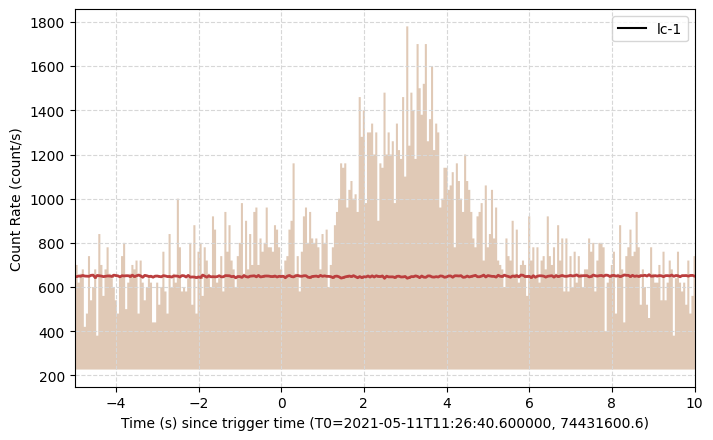

In [44]:
# 画出总时长光变（合并各个能段）
det_sliced_lc_fig = LightCurveFigure(det_sliced_lc.get_plot_data(), trig_time=trig_met, dpi=100)
# 画出本底
det_sliced_lc_fig.add_background(det_sliced_bg_lc.get_plot_data(),
                                 bg_time_range=det_sliced_bg_lc.bg_time_range)
# 画出源时间段的阴影
det_sliced_lc_fig.add_selection(det_src_lc.get_plot_data())
det_sliced_lc_fig.set_xlim([-5,10])
det_sliced_lc_fig.show_legend()
plt.show()

In [13]:
import numpy as np

In [18]:
np.vstack((det_sliced_lc.time_bins[:-1],np.diff(det_sliced_lc.time_bins)-det_sliced_lc.dead_time_on_bins))

array([[7.44315506e+07, 7.44315526e+07, 7.44315546e+07, 7.44315566e+07,
        7.44315586e+07, 7.44315606e+07, 7.44315626e+07, 7.44315646e+07,
        7.44315666e+07, 7.44315686e+07, 7.44315706e+07, 7.44315726e+07,
        7.44315746e+07, 7.44315766e+07, 7.44315786e+07, 7.44315806e+07,
        7.44315826e+07, 7.44315846e+07, 7.44315866e+07, 7.44315886e+07,
        7.44315906e+07, 7.44315926e+07, 7.44315946e+07, 7.44315966e+07,
        7.44315986e+07, 7.44316006e+07, 7.44316026e+07, 7.44316046e+07,
        7.44316066e+07, 7.44316086e+07, 7.44316106e+07, 7.44316126e+07,
        7.44316146e+07, 7.44316166e+07, 7.44316186e+07, 7.44316206e+07,
        7.44316226e+07, 7.44316246e+07, 7.44316266e+07, 7.44316286e+07,
        7.44316306e+07, 7.44316326e+07, 7.44316346e+07, 7.44316366e+07,
        7.44316386e+07, 7.44316406e+07, 7.44316426e+07, 7.44316446e+07,
        7.44316466e+07, 7.44316486e+07, 7.44316506e+07, 7.44316526e+07,
        7.44316546e+07, 7.44316566e+07, 7.44316586e+07],
       

In [25]:
trig_met=evt.info.trig_met

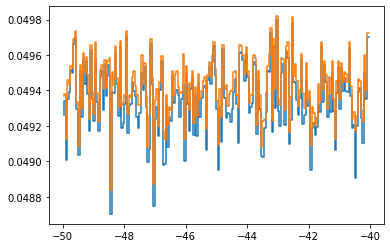

In [10]:
tool_time=det_sliced_lc.time_bins[:-1]
tool_exposure=np.diff(det_sliced_lc.time_bins)-det_sliced_lc.dead_time_on_bins
tool_exposure2=np.diff(det_sliced_lc2.time_bins)-det_sliced_lc2.dead_time_on_bins

plt.step(tool_time-trig_met,tool_exposure)
plt.step(tool_time-trig_met,tool_exposure2)

In [11]:
from astropy.io import fits

In [12]:
time_bin_obj=fits.open(r"E:\gecamTools\test\GECAMB_0D_BIN_TIME_GRD_20210511T110000_0BB.FITS")

In [13]:
time_bins_grd18=time_bin_obj["BIT_GRD18"].data

In [14]:
grd18_filtered=time_bins_grd18[(time_bins_grd18["TT_TIME"]>=74431550.65)&(time_bins_grd18["TT_TIME"]<74431560.65)]

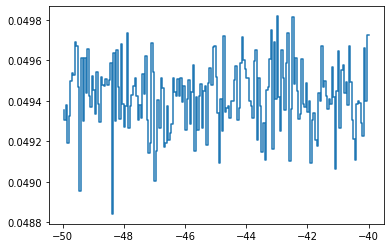

In [15]:
bin_time=grd18_filtered["TT_TIME"]
bin_exposure=grd18_filtered["EXPOSURE"][:,0]

plt.step(bin_time-trig_met,bin_exposure)

In [48]:
tool_time.shape,bin_time.shape,

((199,), (200,))

In [39]:
tool_time[-1],bin_time[-1]

(74431660.39999346, 74431660.45)

In [40]:
tool_time[0],bin_time[0]

(74431550.65, 74431550.65)

In [26]:
det_sliced_lc.time_bins.tolist()[-1]

74431660.44999346

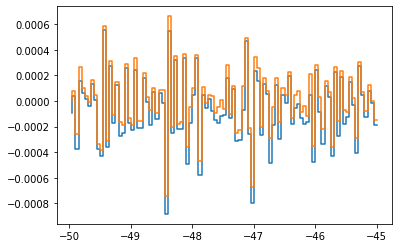

In [21]:
choose_index=100

plt.step(tool_time[:choose_index]-trig_met,tool_exposure[:choose_index]-bin_exposure[:choose_index])
plt.step(tool_time[:choose_index]-trig_met,tool_exposure2[:choose_index]-bin_exposure[:choose_index])

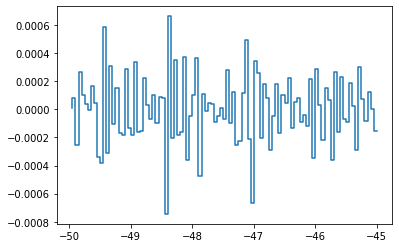

In [19]:
choose_index=100

plt.step(tool_time[:choose_index]-trig_met,tool_exposure2[:choose_index]-bin_exposure[:choose_index])

## 3.6 查看各个能段的拟合结果评价

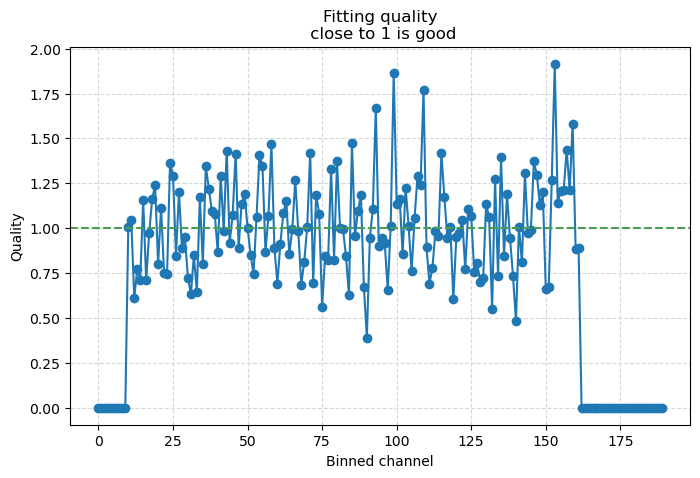

In [14]:
# 选择查看，并道后的第10至100道的拟合结果评价指标，None:为查看所有道
# 当前指标越接近1越好
channel_range = [10, 200]
det_sliced_bg_lc.show_fitting_quality(channel_range=channel_range)
plt.show()


# 对于某个能道拟合效果不好，
# 则后续程序，可查看该能段的光变，或重新单独拟合该能段的本底

## 3.7 画出能段序号为100的光变

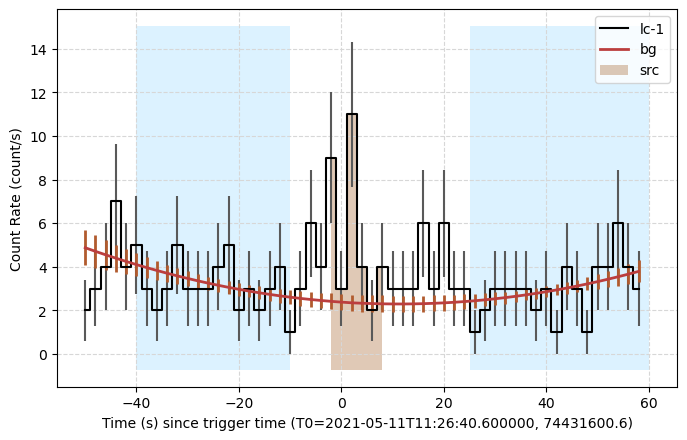

In [12]:
# 设置能段序号为100 （如果生成分能段光变时有进行并道，则选取并道后的能段序号）
choose_channel_index = 100

# 过滤选取能段的光变
channel_lc = det_sliced_lc.get_channel_lc(choose_channel_index)  # 总长度光变
channel_src_lc = det_src_lc.get_channel_lc(choose_channel_index)  # 源区间光变
channel_bg_lc = det_sliced_bg_lc.get_channel_lc(choose_channel_index)  #本底区间光变

# 画光变
det_sliced_c_lc_fig = LightCurveFigure(channel_lc.get_plot_data(), trig_time=trig_met)
# 标记本底范围的阴影
det_sliced_c_lc_fig.add_background(channel_bg_lc.get_plot_data(),
                                   bg_time_range=channel_bg_lc.bg_time_range, label="bg")
#  标记源时间段
det_sliced_c_lc_fig.add_selection(channel_src_lc.get_plot_data(), label="src")
det_sliced_c_lc_fig.show_legend()
# plt.show()

## 3.8 调整单个能段的本底拟合

['2pass', 2, 4.573404187406723, 12.0, 0.38111701561722694]


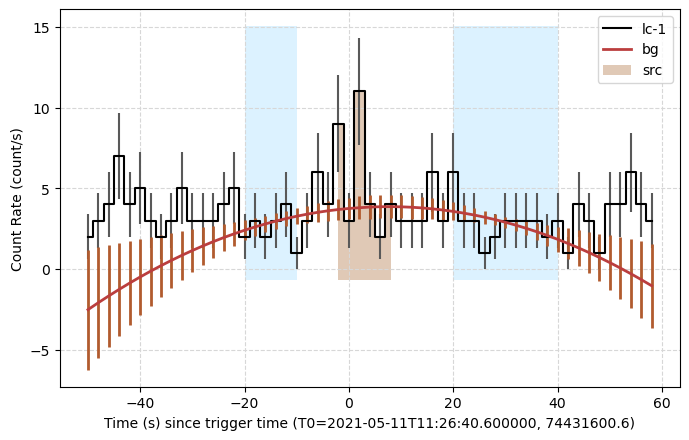

In [18]:
# 选择能段序号为100，（如果生成分能段光变时有进行并道，则选取并道后的能段序号）
choose_channel_index = 100

bg_time_range_list2 = [[trig_met - 20, trig_met - 10], [trig_met + 20, trig_met + 40]]
fit_order = 2

channel_lc = det_sliced_lc.get_channel_lc(choose_channel_index)
channel_bg_lc = channel_lc.fit_background(bg_time_range_list2, fit_order=fit_order)
print(channel_bg_lc.fit_info)

channel_src_lc = det_src_lc.get_channel_lc(choose_channel_index)

det_c_lc_fig = LightCurveFigure(channel_lc.get_plot_data(), trig_time=trig_met)
det_c_lc_fig.add_background(channel_bg_lc.get_plot_data(),
                            bg_time_range=channel_bg_lc.bg_time_range, label="bg")
det_c_lc_fig.add_selection(channel_src_lc.get_plot_data(), label="src")
det_c_lc_fig.show_legend()

## 3.9 生成当前探头的能谱

In [42]:
# 生成能谱文件的数据,时间分解谱

src_time_range = (trig_met - 1, trig_met + 9)
spec_file = SpecFile(det_sliced_lc, det_sliced_bg_lc)
# 添加第一个源时间段
spec, bg_spec, net_spec = spec_file.add_src(src_time_range)

# 添加第二个源时间段
src_time_range2 = (trig_met + 9, trig_met + 15)
spec2, bg_spec2, net_spec2 = spec_file.add_src(src_time_range2)

/root/miniconda3/envs/gecamTools/lib/python3.6/site-packages/gecam/data/spec.py:83: RuntimeWarning: invalid value encountered in sqrt
  net_spec_err = np.sqrt(net_spec_data)


## 3.10 查看能谱

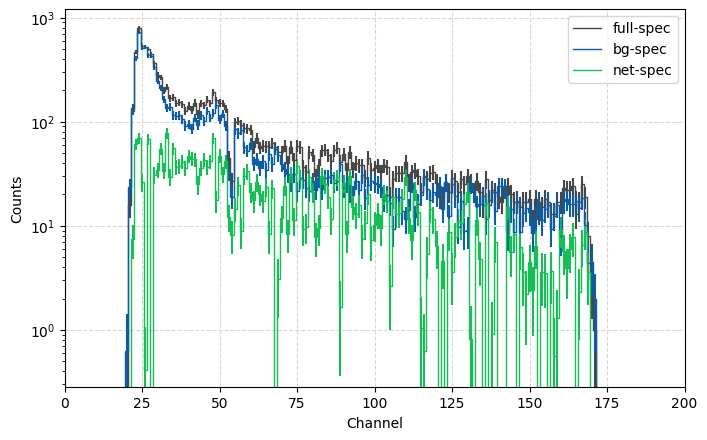

In [53]:
# 画出能谱文件的数据（当前选择第一段源时间段的能谱）
spec_fig = SpectrumFigure()
spec_fig.add_data(spec.get_plot_data(), color="#474747", err_color="#474747", label="full-spec", linewidth=1)
spec_fig.add_data(bg_spec.get_plot_data(), color="#0c5da5", err_color="#0c5da5", label="bg-spec", linewidth=1)
spec_fig.add_data(net_spec.get_plot_data(), color="#16bf55", err_color="#16bf55", label="net-spec", linewidth=1)

# 截断显示
spec_fig.set_xlim([0, 200])
spec_fig.show_legend()
plt.show()


## 3.10 输出能谱到能谱文件中

In [29]:

# 能谱对应的响应文件
rsp_path = "test.rsp"
out_dir = r"./"
spec_file.write(out_dir, rsp_path=rsp_path)